In [ ]:
# prompt: mount with drive and access a folder for dataset importing

from google.colab import drive
drive.mount('/content/drive')


# Replace 'path/to/your/dataset' with the actual path to your dataset in Google Drive
# data = pd.read_csv('/content/drive/My Drive/path/to/your/dataset/your_file.csv')
# print(data.head())


In [4]:
import json
import csv
import pandas as pd
import numpy as np
from collections import defaultdict

# folder_path='/content/drive/My Drive/DataExtractor/'
folder_path=''
# Load JSON data
with open(folder_path+"Merged_data.json", "r") as json_file:
    data = json.load(json_file)
    
folder = folder_path+"Merged_Data/"

In [5]:

entries = []
scan_lists = []

entry_id = 1
scan_id = 1
for room_no, room_data in data.items():
    for entry in room_data.values():
        # Calculate number of scans and average data per scan
        scan_list = entry.get("ScanList", [])
        num_scans = len(scan_list)

        if num_scans == 0:
            continue  # Skip entries with 0 scans

        avg_data_per_scan = (
            sum(len(scan_group) for scan_group in scan_list) / num_scans if num_scans > 0 else 0
        )

        # Extract metadata for entries.csv
        entries.append([
            entry_id,
            room_no,
            entry.get("StudentID"),
            entry.get("DeviceModel"),
            entry.get("BatteryLifeBefore"),
            entry.get("BatteryLifeAfter"),
            entry.get("DateTime"),
            num_scans,
            round(avg_data_per_scan, 2)  # Rounded to 2 decimal places
        ])

        # Extract scan list for scan_lists.csv
        for group_index, scan_group in enumerate(scan_list):
            for scan in scan_group:
                scan_lists.append([
                    scan_id,
                    entry_id,
                    group_index,
                    scan.get("Frequency"),
                    scan.get("MacAddress"),
                    scan.get("SSID"),
                    scan.get("Strength")
                ])
                scan_id += 1

        entry_id += 1


# Write entries.csv
with open(folder + "entries.csv", "w", newline="") as entries_file:
    writer = csv.writer(entries_file)
    writer.writerow(["entryId", "roomNo", "StudentID", "DeviceModel", "BatteryLifeBefore", "BatteryLifeAfter", "DateTime", "NumScans", "AvgDataPerScan"])
    writer.writerows(entries)

# Write scan_lists.csv
with open(folder + "scan_lists.csv", "w", newline="") as scan_lists_file:
    writer = csv.writer(scan_lists_file)
    writer.writerow(["scanId", "entryId", "scanGroupIndex", "Frequency", "MacAddress", "SSID", "Strength"])
    writer.writerows(scan_lists)

print("CSV files created successfully!")


CSV files created successfully!


In [ ]:
# File paths
scan_list_csv = folder+"scan_lists.csv"

# Data structures to store statistics
ssid_counts = defaultdict(int)  # To count occurrences of each SSID
mac_to_ssid = defaultdict(set)  # To map each MAC address to the corresponding SSIDs
ssid_to_macs = defaultdict(lambda: defaultdict(int))  # To count MAC addresses per SSID

# Read the scan_lists.csv file
with open(scan_list_csv, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        ssid = row["SSID"]
        mac_address = row["MacAddress"]

        # Update SSID count
        ssid_counts[ssid] += 1

        # Map MAC address to SSIDs
        mac_to_ssid[mac_address].add(ssid)

        # Count MAC addresses for each SSID
        ssid_to_macs[ssid][mac_address] += 1

# Check if each MAC corresponds to a unique SSID
mac_unique_ssid = {mac: len(ssids) == 1 for mac, ssids in mac_to_ssid.items()}

# Display the results
print("SSID statistics:")
for ssid, count in ssid_counts.items():
    print(f"SSID: {ssid}, Total Count: {count}")
    print("  MAC Addresses and their counts:")
    for mac, mac_count in ssid_to_macs[ssid].items():
        print(f"    MAC: {mac}, Count: {mac_count}")
    print()


In [ ]:

# File paths
scan_list_csv = folder + "scan_lists.csv"

# Data structures to store statistics
mac_counts = defaultdict(int)  # To count occurrences of each MAC address
mac_to_ssid_counts = defaultdict(lambda: defaultdict(int))  # To count SSIDs under each MAC address

# Read the scan_lists.csv file
with open(scan_list_csv, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        ssid = row["SSID"]
        mac_address = row["MacAddress"]

        # Update MAC address count
        mac_counts[mac_address] += 1

        # Count SSID occurrences under each MAC address
        mac_to_ssid_counts[mac_address][ssid] += 1

# Display the results
print("MAC Address Count and Corresponding SSID Counts:")
for mac, mac_count in mac_counts.items():
    print(f"MAC: {mac}, Total Count: {mac_count}")
    print("  SSID(s) and their counts:")
    for ssid, ssid_count in mac_to_ssid_counts[mac].items():
        print(f"    SSID: {ssid}, Count: {ssid_count}")
    print()

In [6]:
# File paths
scan_list_csv = folder+"scan_lists.csv"
entries_csv = folder+"entries.csv"
output_csv = folder+"mac_address_statistics.csv"


# Data structure to store scan data per entryId
entry_scans = defaultdict(list)

# Data structure to store total number of scans per entryId (from entries.csv)
entry_num_scans = {}

# Read the entries.csv file and get the total number of scans for each entryId
with open(entries_csv, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        entry_id = int(row["entryId"])
        num_scans = int(row["NumScans"])
        entry_num_scans[entry_id] = num_scans

# Read the scan_lists.csv file and collect scan data
with open(scan_list_csv, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        entry_id = int(row["entryId"])
        mac_address = row["MacAddress"]
        ssid = row["SSID"]
        strength = int(row["Strength"])

        entry_scans[entry_id].append({
            "mac_address": mac_address,
            "ssid": ssid,
            "strength": strength
        })

# Remove outliers (top 20% and bottom 20%)
def remove_outliers(data):
    if len(data) < 5:  # Not enough data to remove outliers
        return data
    sorted_data = sorted(data)
    n = len(sorted_data)
    lower_index = int(n * 0.2)
    upper_index = int(n * 0.8)
    return sorted_data[lower_index:upper_index]

# Prepare the list for output CSV
output_data = []

# Process each entryId and its corresponding scans
for entry_id, scans in entry_scans.items():
    mac_stats = defaultdict(list)
    mac_to_ssid = {}

    # Collect scan data for each MAC address
    for scan in scans:
        mac_address = scan["mac_address"]
        ssid = scan["ssid"]
        strength = scan["strength"]
        
        mac_to_ssid[mac_address] = ssid

        # Store the strength for averaging
        mac_stats[mac_address].append(strength)

    # Process each MAC address for statistics
    for mac_address, strengths in mac_stats.items():
        num_scans = entry_num_scans.get(entry_id, 0)  # Get total scans for entryId from entry_num_scans

        # Average strength and standard deviation
        avg_strength = np.mean(strengths)
        std_dev = np.std(strengths)

        # Calculate the average strength and standard deviation after removing outliers
        filtered_strengths = remove_outliers(strengths)
        avg_strength_no_outliers = np.mean(filtered_strengths) if filtered_strengths else 0
        std_dev_no_outliers = np.std(filtered_strengths) if filtered_strengths else 0
        count_no_outliers = len(filtered_strengths)

        ssid = mac_to_ssid[mac_address]

        # Add the row to output data
        output_data.append([
            entry_id,  # The entryId
            num_scans,  # The total number of scans for the entryId (same for all rows of the same entryId)
            mac_address,  # The MAC address
            ssid,  # The SSID (consistent for each MAC address in the entry)
            len(strengths),  # The count of scans for this particular MAC address
            round(avg_strength, 2),  # Average strength
            round(std_dev, 2),  # Standard deviation
            round(avg_strength_no_outliers, 2),  # Average strength after removing outliers
            count_no_outliers,  # Count of valid scans after removing outliers
            round(std_dev_no_outliers, 2)  # Standard deviation after removing outliers
        ])

# Write the results to the new CSV file
with open(output_csv, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow([
        "entryId", "numOfScans", "macAddress", "ssid", "countOfMac",
        "avgStrength", "stdDev", "avgStrengthNoOutliers", "countNoOutliers", "stdDevNoOutliers"
    ])
    writer.writerows(output_data)

print("Statistics CSV created successfully!")


Statistics CSV created successfully!


In [7]:

# Load the input CSV
input_csv = folder+"mac_address_statistics.csv"  # Replace with your actual file name
data = pd.read_csv(input_csv)

# Group by macAddress, aggregate count, and retain unique ssid
result = (
    data.groupby("macAddress")
    .agg(
        ssid=("ssid", "first"),  # Get the first (and only) ssid per macAddress
        total_count=("macAddress", "size"),  # Count the occurrences
    )
    .reset_index()
)

# Sort by total count in descending order
result = result.sort_values(by="total_count", ascending=False)

# Save to a new CSV
output_csv = folder+"mac_count.csv"  # Desired output file name
result.to_csv(output_csv, index=False)

print("New CSV file created successfully:", output_csv)


New CSV file created successfully: Merged_Data/mac_count.csv


In [19]:

# Define the SafeMacs list
SafeMacs = [
    "60:63:4c:31:37:40", "30:b5:c2:ea:5b:44", "18:0f:76:c3:06:8d", "00:22:b0:05:f3:bc",
    "bc:22:28:21:09:21", "36:20:f9:a1:88:62", "36:20:f9:a1:88:56", "bc:22:28:21:09:24",
    "36:62:f9:a1:88:63", "bc:22:28:21:55:6b", "34:e8:94:10:7d:fa", "36:20:f9:a1:8b:8e",
    "36:20:f9:a1:8b:8e", "5e:a9:31:22:bb:0a", "bc:22:28:21:55:6e", "bc:22:28:21:09:ba",
    "26:2f:d0:88:39:a2", "36:62:f9:a1:88:57", "60:63:4c:31:37:60", "10:62:eb:77:b7:42",
    "00:1e:2a:ba:c8:20", "70:4c:a5:95:b6:00", "60:63:4c:31:37:48"
]

# Load the input CSV
input_csv = folder+"mac_address_statistics.csv"
data = pd.read_csv(input_csv)

# Filter rows where macAddress is in the SafeMacs list
filtered_data = data[data["macAddress"].isin(SafeMacs)]

# Save the filtered data to a new CSV
output_csv = folder+"filtered_output.csv"  # Desired output file name
filtered_data.to_csv(output_csv, index=False)

print("Filtered CSV file created successfully:", output_csv)

Filtered CSV file created successfully: Merged_Data/filtered_output.csv


In [20]:
# Load the additional CSV with room information
room_info_csv = folder+"entries.csv"  # Replace with the actual file name
room_data = pd.read_csv(room_info_csv)

# Create a pivot table with entryId as rows, macAddress as columns, and avgStrengthNoOutliers as values
pivot_table = filtered_data.pivot_table(
    index="entryId", columns="macAddress", values="avgStrengthNoOutliers", aggfunc="mean"
)

# Fill missing values with -90
pivot_table = pivot_table.fillna(-90)

# Add a multi-index column for macAddress and SSID
ssid_mapping = dict(zip(filtered_data["macAddress"], filtered_data["ssid"]))
column_tuples = [(mac, ssid_mapping.get(mac, "Unknown")) for mac in SafeMacs]
pivot_table = pivot_table.reindex(columns=[mac for mac, _ in column_tuples], fill_value=-90)
pivot_table.columns = pd.MultiIndex.from_tuples(column_tuples, names=["macAddress", "SSID"])

# Flatten the multi-level columns and convert each element to a string before joining
pivot_table.columns = ["_".join(str(col) for col in item).strip() for item in pivot_table.columns]

# Reset index to make entryId a column
pivot_table = pivot_table.reset_index()

# Merge with room information using entryId
merged_data = pd.merge(room_data[["entryId", "roomNo"]], pivot_table, on="entryId", how="left")

# Save the matrix to a new CSV
output_csv = folder+"matrix.csv"
merged_data.to_csv(output_csv, index=False)

print("Transformed CSV file created successfully:", output_csv)

Transformed CSV file created successfully: Merged_Data/matrix.csv


/home/nahin/anaconda3/envs/image_ml/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


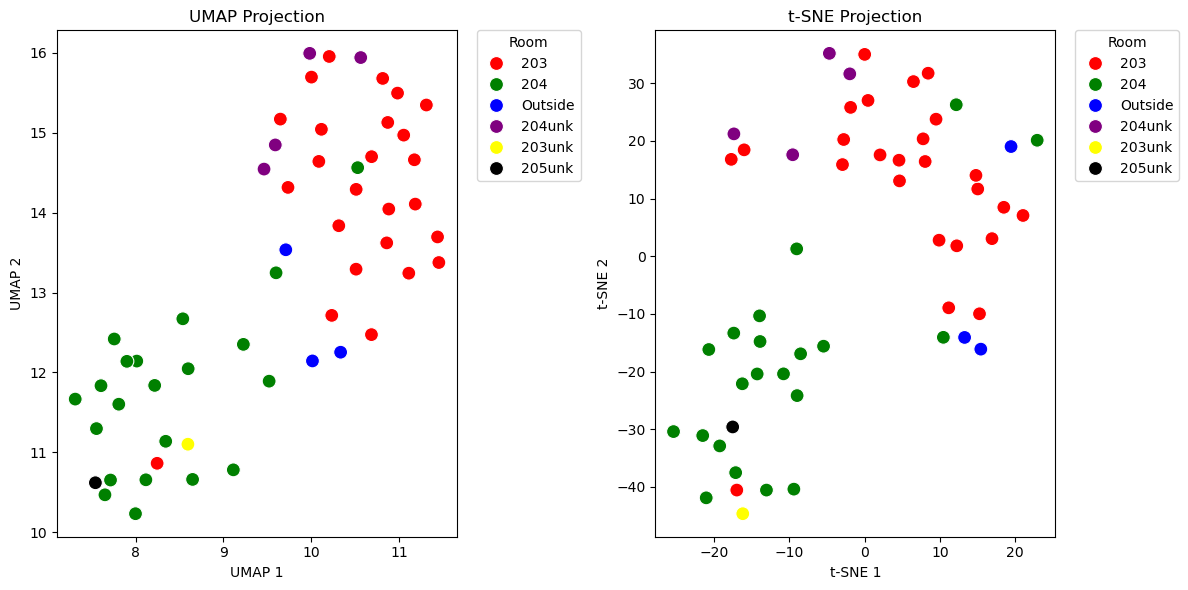

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

data = pd.read_csv(folder+"matrix.csv")

# Extract features (columns starting from the 3rd)
features = data.iloc[:, 2:].values

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Generate UMAP embeddings
umap_reducer = UMAP(random_state=42)
umap_embedding = umap_reducer.fit_transform(features_scaled)

# Generate t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_embedding = tsne.fit_transform(features_scaled)

# Define custom color palette for rooms
custom_palette = {
    '203': 'red',
    '204': 'green',
    'Outside': 'blue',
    '203unk': 'yellow',
    '204unk': 'purple',
    '205unk': 'black'
}

# Plot UMAP
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    hue=data["roomNo"],
    palette=custom_palette,  # Use custom palette
    s=100
)
plt.title("UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Room", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_embedding[:, 0],
    y=tsne_embedding[:, 1],
    hue=data["roomNo"],
    palette=custom_palette,  # Use custom palette
    s=100
)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Room", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Adjust layout to make space for the legends outside the plots
plt.tight_layout()

# Show plot
plt.show()


/tmp/ipykernel_38187/291576354.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dbscan_palette = {label: plt.cm.get_cmap('tab20')(i) for i, label in enumerate(unique_clusters)}


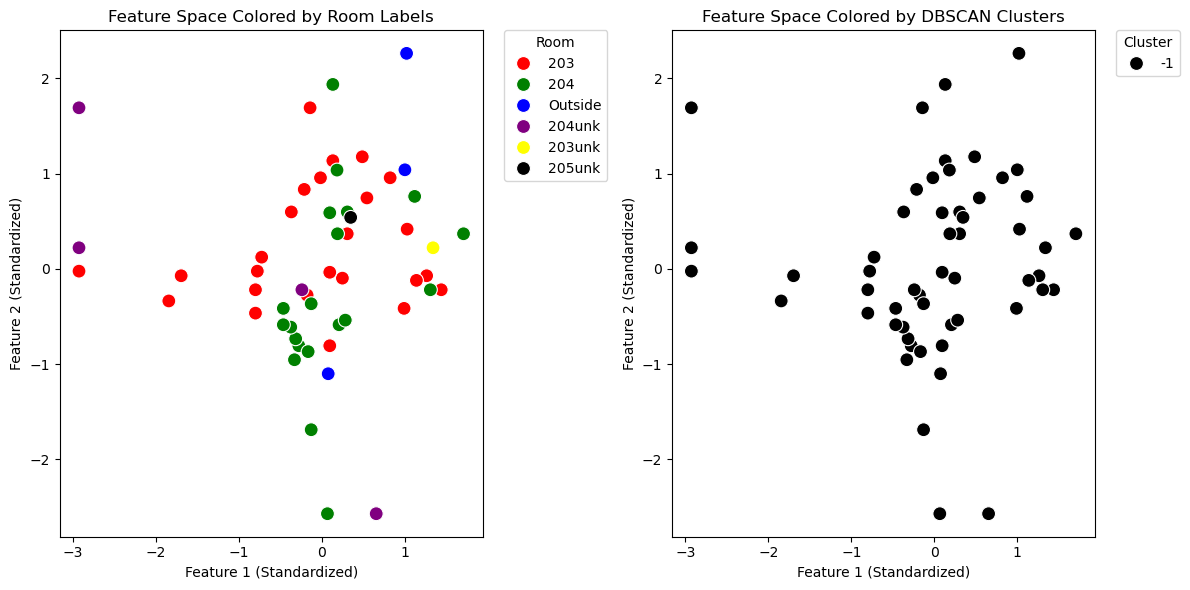

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Load your data
data = pd.read_csv(folder + "matrix.csv")

# Extract features (columns starting from the 3rd)
features = data.iloc[:, 2:].values

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust parameters as needed
dbscan_labels = dbscan.fit_predict(features_scaled)

# Add DBSCAN labels to the DataFrame
data['DBSCAN_Cluster'] = dbscan_labels

# Define custom color palette for room labels
custom_palette = {
    '203': 'red',
    '204': 'green',
    'Outside': 'blue',
    '203unk': 'yellow',
    '204unk': 'purple',
    '205unk': 'black'
}

# Define a color palette for DBSCAN clusters
unique_clusters = set(dbscan_labels)
dbscan_palette = {label: plt.cm.get_cmap('tab20')(i) for i, label in enumerate(unique_clusters)}
dbscan_palette[-1] = 'black'  # Mark outliers (-1) with black

# Visualize room labels in feature space
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=features_scaled[:, 0],  # First feature (arbitrary for visualization)
    y=features_scaled[:, 1],  # Second feature (arbitrary for visualization)
    hue=data['roomNo'],       # Room labels
    palette=custom_palette,
    s=100,
    legend='full'
)
plt.title("Feature Space Colored by Room Labels")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend(title="Room", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Visualize DBSCAN clusters in feature space
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=features_scaled[:, 0],  # First feature (arbitrary for visualization)
    y=features_scaled[:, 1],  # Second feature (arbitrary for visualization)
    hue=data['DBSCAN_Cluster'],  # DBSCAN cluster labels
    palette=dbscan_palette,
    s=100,
    legend='full'
)
plt.title("Feature Space Colored by DBSCAN Clusters")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()
